[(array([210., 230., 236., 146., 102.,  64.,   7.,   2.,   2.,   1.]),
  array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
  <BarContainer object of 10 artists>),
 (array([210., 230., 236., 146., 102.,  64.,   7.,   2.,   2.,   1.]),
  array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
  <BarContainer object of 10 artists>)]

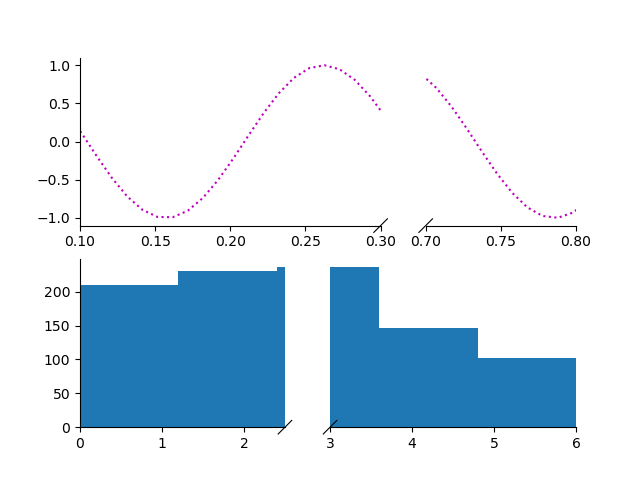

In [1]:
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec
import numpy as np

sps1, sps2 = GridSpec(2,1)

bax = brokenaxes(xlims=((.1, .3), (.7, .8)), subplot_spec=sps1)
x = np.linspace(0, 1, 100)
bax.plot(x, np.sin(x*30), ls=':', color='m')

x = np.random.poisson(3, 1000)
bax = brokenaxes(xlims=((0, 2.5), (3, 6)), subplot_spec=sps2)
bax.hist(x, histtype='bar')

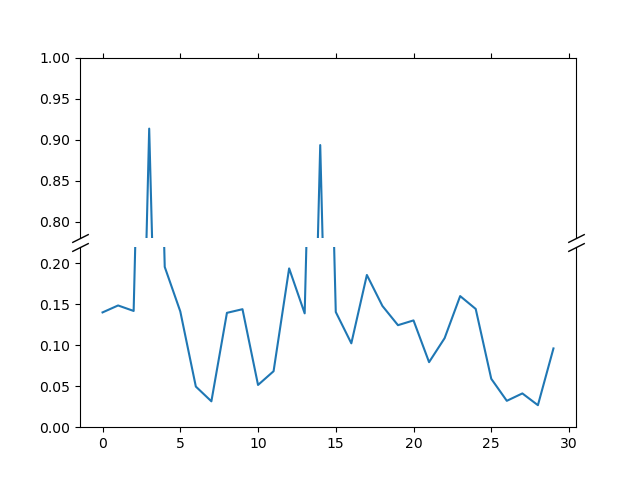

In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)

pts = np.random.rand(30)*.2
# Now let's make two outlier points which are far away from everything.
pts[[3, 14]] += .8

# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax1) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# plot the same data on both axes
ax1.plot(pts)
ax2.plot(pts)

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(.78, 1.)  # outliers only
ax2.set_ylim(0, .22)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


In [4]:
from pathlib import Path
from neuropy.io import NeuroscopeIO,BinarysignalIO

file = Path('/data/Clustering/sessions/RatA14d1LP/Rollipram/RatA14d1LP_Day1_2020-02-21_04-47-30.xml')
recinfo = NeuroscopeIO(file)

eegfile = BinarysignalIO(
            recinfo.eeg_filename,
            n_channels=recinfo.n_channels,
            sampling_rate=recinfo.eeg_sampling_rate,
        )
# write_filename = file.with_suffix('.maze.eeg')
# eegfile.write_time_slice(write_filename,11824,16024)

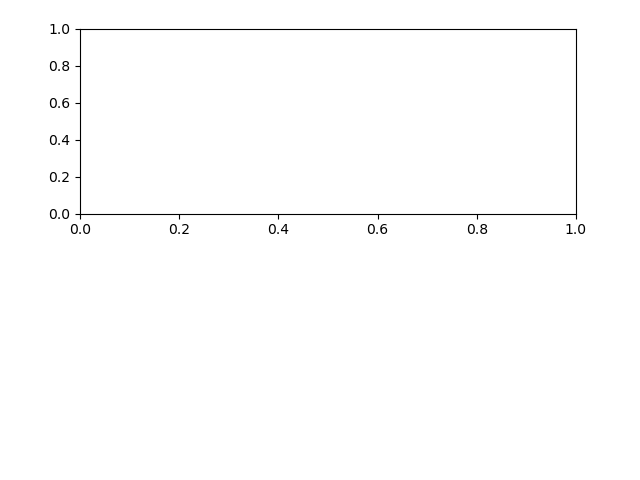

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.figure import SubFigure
# a = GridSpec(2,3)

class MyFig(GridSpec):
    def __init__(self,nrows,ncols,**kwargs):
        super().__init__(nrows,ncols,**kwargs)
# _,axs = plt.subplots(2,2,gridspec_kw=dict(height_ratios=[1,3]))

# _,axs = plt.subplots(2,2)
fig = plt.figure()
gs = GridSpec(2,2,figure=fig)

def add_s(*args,**kwargs)->mpl.figure.SubFigure:
    return fig.add_subfigure(*args,**kwargs)


subfig = add_s(gs[0,:])

In [ ]:
fig = MyFig(2,3)
fig.add_subfigure()

In [ ]:
import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Create the PdfPages object to which we will save the pages:
# The with statement makes sure that the PdfPages object is closed properly at
# the end of the block, even if an Exception occurs.
with PdfPages('multipage_pdf.pdf') as pdf:
    plt.figure(figsize=(3, 3))
    plt.plot(range(7), [3, 1, 4, 1, 5, 9, 2], 'r-o')
    plt.title('Page One')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    

    # if LaTeX is not installed or error caught, change to `False`
    plt.rcParams['text.usetex'] = False
    plt.figure(figsize=(8, 6))
    x = np.arange(0, 5, 0.1)
    plt.plot(x, np.sin(x), 'b-')
    plt.title('Page Two')
    pdf.attach_note("plot of sin(x)")  # attach metadata (as pdf note) to page
    pdf.savefig()
    plt.close()

    plt.rcParams['text.usetex'] = False
    fig = plt.figure(figsize=(4, 5))
    plt.plot(x, x ** 2, 'ko')
    plt.title('Page Three')
    pdf.savefig(fig)  # or you can pass a Figure object to pdf.savefig
    plt.close()

    # We can also set the file's metadata via the PdfPages object:
    d = pdf.infodict()
    d['Title'] = 'Multipage PDF Example'
    d['Author'] = 'Jouni K. Sepp\xe4nen'
    d['Subject'] = 'How to create a multipage pdf file and set its metadata'
    d['Keywords'] = 'PdfPages multipage keywords author title subject'
    d['CreationDate'] = datetime.datetime(2009, 11, 13)
    d['ModDate'] = datetime.datetime.today()


In [ ]:
from matplotlib import figure
f = figure.Figure(constrained_layout=True, figsize=(8, 4))
sf1, sf2 = f.subfigures(1, 2)

axs = sf1.subplot_mosaic('AB;CD;CD;CD')

# axs[1:,0].plot([1,2,3])
# sf1.add_gridspec()
# sf1.add_subfigure()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate fake data
x = np.random.normal(size=1000)
y = x * 3 + np.random.normal(size=1000)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy,bw_method=50)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50,cmap='Greys',marker='.')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

fig, axs = plt.subplot_mosaic([['a)', 'c)'], ['b)','.'], ['d)', 'd)']],
                              constrained_layout=True)

# axs['a)'].plot([1,2,3],[1,2,3])
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

In [ ]:
from ephyviewer import mkQApp, MainViewer, TraceViewer
import numpy as np
from ephyviewer_position import PositionViewer
import subjects

position = subjects.sd.ratSday3[0].position.time_slice(10000,12000)

#you must first create a main Qt application (for event loop)
app = mkQApp()

#create fake 16 signals with 100000 at 10kHz
sigs = position.traces.T
sample_rate = position.sampling_rate
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
# TraceViewer normally accept a AnalogSignalSource but
# TraceViewer.from_numpy is facitilty function to bypass that
# view1 = TraceViewer.from_numpy(sigs, sample_rate, t_start, 'Signals')
view1=PositionViewer.from_numpy(sigs, sample_rate, t_start, 'Signals')

#Parameters can be set in script
# view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True

#And also parameters for each channel
# view1.by_channel_params['ch0', 'visible'] = False
# view1.by_channel_params['ch1', 'color'] = '#FF00AA'

#This is needed when scale_mode='same_for_all'
#to recompute the gain
#this avoid to push auto_scale button
view1.auto_scale()

#put this veiwer in the main window
win.add_view(view1)

#show main window and run Qapp
win.show()


app.exec_()


In [ ]:
from ephyviewer.tools import mkCachedBrush

mkCachedBrush('#FFFFFF')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(sigs[:,0],sigs[:,1])

In [ ]:
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer
import numpy as np

#you must first create a main Qt application (for event loop)
app = mkQApp()

#create 16 signals with 100000 at 10kHz
sigs = np.random.rand(100000,16)
sample_rate = 1000.
t_start = 0.


#create fake 16 signals with sinus
sample_rate = 1000.
t_start = 0.
times = np.arange(1000000)/sample_rate
signals = np.sin(times*2*np.pi*5)[:, None]
signals = np.tile(signals, (1, 16))

#detect some crossing zeros
s0 = signals[:-2, 0]
s1 = signals[1:-1,0]
s2 = signals[2:,0]
peaks0,  = np.nonzero((s0<s1) & (s2<s1))
peaks1,  = np.nonzero((s0>s1) & (s2>s1))

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: peaks0, 1: peaks1}
#and asign them to some channels each
scatter_channels = {0: [0, 5, 8], 1: [0, 5, 10]}
source = AnalogSignalSourceWithScatter(signals, sample_rate, t_start, scatter_indexes, scatter_channels)


#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

view1.params['scale_mode'] = 'same_for_all'
view1.auto_scale()

#put this veiwer in the main window
win.add_view(view1)

#show main window and run Qapp
win.show()
app.exec_()

In [ ]:
from ephyviewer import mkQApp, MainViewer, TraceViewer, SpikeTrainViewer, EpochViewer, EventList
from ephyviewer import get_sources_from_neo_segment, compose_mainviewer_from_sources
import numpy as np


from neo.test.generate_datasets import generate_one_simple_segment
import neo


# here we generate a segment with several objects
# (this is a bad example because it mimics old neo behavior for signals (one channel=one object))
neo_seg = generate_one_simple_segment(supported_objects=[neo.Segment, neo.AnalogSignal, neo.Event, neo.Epoch, neo.SpikeTrain])

# the global QT app
app = mkQApp()


##############################
# case 1 : create viewers one at a time directly from neo objects in memory
win = MainViewer(show_auto_scale=True)
TraceViewer.from
# from one neo.AnalogSignal
view1 = TraceViewer.from_neo_analogsignal(neo_seg.analogsignals[0], 'sigs')
win.add_view(view1)

# from several neo.SpikeTrains (3 spiketrains here)
view2 = SpikeTrainViewer.from_neo_spiketrains(neo_seg.spiketrains[0:3], 'spikes')
win.add_view(view2)

# from several neo.Epoch
view3 = EpochViewer.from_neo_epochs(neo_seg.epochs, 'epochs')
win.add_view(view3)

# from several neo.Event
view4 = EventList.from_neo_events(neo_seg.events, 'events')
win.add_view(view4, location='bottom',  orientation='horizontal')

win.show()





##############################
# case 2 : automagically create data sources and a complete window from a neo segment
sources = get_sources_from_neo_segment(neo_seg)
win2 = compose_mainviewer_from_sources(sources)
win2.show()


app.exec_()


In [ ]:
%matplotlib widget
import seaborn as sns
import pandas as pd
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt

df = sns.load_dataset("tips")
df['tip_bucket'] = pd.cut(df['tip'], 3)
tip_bucket_list = df['tip_bucket'].unique()
order = ['Sun', 'Thur', 'Fri', 'Sat']
x = "day"
y = "total_bill"
hue = "tip_bucket"
data = df
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
# method calls can be queued
annot = Annotator(ax, [("Thur", "Fri"), ("Thur", "Sat"), ("Fri", "Sun")], data=df, x=x, y=y, order=order)
(annot
 .reset_configuration()
 .new_plot(ax, [(("Sat", tip_bucket_list[2]), ("Fri", tip_bucket_list[0]))],
           data=df, x=x, y=y, hue=hue)
 .configure(test='t-test_ind')
 .apply_test()
 .annotate())

# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))


In [ ]:
"""
ephyviewer also provides an epoch encoder which can be used with shortcut keys
and/or the mouse to encode labels.

ephyviewer makes available a CsvEpochSource class, which inherits from
WritableEpochSource. If you would like to customize reading and writing epochs
to files, you can write your own subclass of WritableEpochSource that implements
the load() and save() methods.

Here is an example of an epoch encoder that uses CsvEpochSource.

"""

from ephyviewer import mkQApp, MainViewer, TraceViewer, CsvEpochSource, EpochEncoder
import numpy as np



# lets encode some dev mood along the day
possible_labels = ['euphoric', 'nervous', 'hungry',  'triumphant']

filename = 'example_dev_mood_encoder.csv'
source_epoch = CsvEpochSource(filename, possible_labels)



#you must first create a main Qt application (for event loop)
app = mkQApp()

#create fake 16 signals with 100000 at 10kHz
sigs = np.random.rand(100000,16)
sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal
view1 = TraceViewer.from_numpy(sigs, sample_rate, t_start, 'Signals')
view1.params['scale_mode'] = 'same_for_all'
view1.auto_scale()
win.add_view(view1)

#create a viewer for the encoder itself
view2 = EpochEncoder(source=source_epoch, name='Dev mood states along day')
view2.by_label_params['label0','color'] = '#d16161'
view2.params['background_color']='#ffffff'
win.add_view(view2)


#show main window and run Qapp
win.show()


app.exec_()


# press '1', '2', '3', '4' to encode state.
# or toggle 'Time range selector' and then use 'Insert within range'


In [ ]:
from pathlib import Path
import numpy as np

class A:
    # __slots__ = 'path','ripple_psd','ripple_rate'
    def __init__(self) -> None:
        self.path = Path("/home/bapung/Dropbox (University of Michigan)/ProcessedData")
        for f in self.path.iterdir():
            setattr(self,f.name,self.load(f.stem))

    def load(self, fp):
        return np.load(self.path / f"{fp}.npy", allow_pickle=True).item()

    # def __getattr__(self,name: str):
    #     return self.load(name)['data'] 


a = A()

In [ ]:
import numpy as np
from scipy.io import loadmat
import h5py

file = '/data/DataGen/wake_new/wake-spikes.mat'
data = h5py.File(file,'r')

In [ ]:
from numba import jit
import numpy as np
import time

x = np.arange(100).reshape(10, 10)

@jit(nopython=True)
def go_fast(a): # Function is compiled and runs in machine code
    trace = 0.0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    return a + trace

# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
go_fast(x)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
go_fast(x)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))


In [ ]:
import numpy as np
import cupy as cp
import time
n=300
### Numpy and CPU
s = time.time()
X_cpu = np.ones((n,n,n))
e = time.time()
print(e - s) ### CuPy and GPU
s = time.time()
X_gpu = cp.ones((n,n,n))
e = time.time()
print(e - s)

In [ ]:
from pathlib import Path
import numpy as np
import subjects

sess = subjects.sd.ratNday1[0]
chan_order = np.concatenate(sess.recinfo.channel_groups)
chan_order = np.concatenate([chan_order ,chan_order[:64]+128]).astype('int')

basefolder = Path("/data2/Clustering/RatU/RatUDay1SD/")
file = basefolder / "RatU_Day1SD_2021-07-22_07-55-46.eeg"
n_channels = 256
# data = np.memmap(file, dtype="int16", mode="r").reshape(-1, n_channels)[:,chan_order]
# data.tofile(basefolder/'RatU_192chan1.eeg',format='int16')

In [ ]:
write_filename=basefolder/'RatU_192chan.eeg'
write_data = np.memmap(
            write_filename, dtype='int16', mode="w+", shape=(data_new.size)
        )
write_data[: data_new.size] = data_new



In [ ]:
import numpy as np
from pathlib import Path
from neuropy.core import Epoch
import subjects

sess = subjects.nsd.ratKday2[0]

file = Path('/data/Clustering/sessions/RatK/Day2/RatK_Day2_2019-08-08_04-00-00.dead')
ep = []
with open(file,mode='r') as f:
    for line in f:
        ep.append(np.asarray(line.strip('\n').split(' ')).astype('float'))
ep = np.asarray(ep)/1000

epochs = Epoch.from_array(ep[:,0],ep[:,1])
epochs.save(sess.filePrefix.with_suffix('.artifact'))

    
# test = file.read_text()


In [ ]:
%matplotlib widget
from neuropy import plotting

plotting.plot_raster(neurons)

In [ ]:
from statsmodels.tsa.ar_model import AutoReg, AutoRegResults
import subjects
from hfuncs import whiten_signal

sess = subjects.sd.ratNday1[0]
# period = sess.paradigm['maze'].flatten()
period = sess.ripple[6000].flatten()
signal = sess.eegfile.get_signal(32,period[0],period[0]+2)
wht = whiten_signal(signal)
# mod = AutoReg(signal,2,old_names=False)
# res = mod.fit()
# new_sig = res.predict(0,len(signal)+1)
# residual = signal-new_sig[2:]
# result = AutoRegResults(mod,)

In [ ]:
import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Create the PdfPages object to which we will save the pages:
# The with statement makes sure that the PdfPages object is closed properly at
# the end of the block, even if an Exception occurs.
with PdfPages('multipage_pdf.pdf') as pdf:
    plt.figure(figsize=(3, 3))
    plt.plot(range(7), [3, 1, 4, 1, 5, 9, 2], 'r-o')
    plt.title('Page One')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

    # if LaTeX is not installed or error caught, change to `False`
    # plt.rcParams['text.usetex'] = False
    plt.figure(figsize=(8, 6))
    x = np.arange(0, 5, 0.1)
    plt.plot(x, np.sin(x), 'b-')
    plt.title('Page Two')
    pdf.attach_note("plot of sin(x)")  # attach metadata (as pdf note) to page
    pdf.savefig()
    plt.close()

    # plt.rcParams['text.usetex'] = False
    fig = plt.figure(figsize=(4, 5))
    plt.plot(x, x ** 2, 'ko')
    plt.title('Page Three')
    pdf.savefig(fig)  # or you can pass a Figure object to pdf.savefig
    plt.close()

    # We can also set the file's metadata via the PdfPages object:
    d = pdf.infodict()
    d['Title'] = 'Multipage PDF Example'
    d['Author'] = 'Jouni K. Sepp\xe4nen'
    d['Subject'] = 'How to create a multipage pdf file and set its metadata'
    d['Keywords'] = 'PdfPages multipage keywords author title subject'
    d['CreationDate'] = datetime.datetime(2009, 11, 13)
    d['ModDate'] = datetime.datetime.today()

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import scipy.signal as sg
f,psd1 = sg.welch(signal.traces[0],fs=1250,nperseg=1250,noverlap=625)
f,psd2 = sg.welch(wht.traces[0],fs=1250,nperseg=1250,noverlap=625)
# f,psd3 = sg.welch(res.resid,fs=1250,nperseg=1250,noverlap=625)
plt.plot(f,psd1)
plt.plot(f,psd2)
# plt.plot(f,psd3)
plt.xscale('log')
plt.yscale('log')
# plt.plot(new_sig)

In [ ]:
import numpy as np
from neuropy.utils.signal_process import WaveletSg

wvlt = WaveletSg(wht,freqs=np.arange(100,250,2),ncycles=10)

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

_, axs = plt.subplots(2, 1, sharex=True)

axs[0].plot(np.linspace(0, 2, len(signal.traces[0])), signal.traces[0], "k")
axs[1].imshow(
    wvlt.traces,
    aspect="auto",
    extent=[0, 2, 100, 250],
    origin="lower",
    interpolation="none",
    # vmax=130,
    cmap='jet',
)
# plt.yscale('log')


In [ ]:
%matplotlib widget

plt.plot(signal.traces[0])
plt.plot(wht.traces[0])


In [ ]:
import subjects

sess = subjects.nsd.ratKday2[0]
maze = sess.paradigm['maze'].flatten()
dest_file = sess.filePrefix.with_suffix('.maze.eeg')
sess.eegfile.write_time_slice(dest_file,int(maze[0]),int(maze[1]))

In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

file_name = "RatU_Day4SD_2021-07-29_08-23-06.eeg_sample.eeg"
n_channels = 192 # number of recorded channels in the file
sampling_rate = 1250
# reading data from binary file and reshaping to n_channels x time format
data = np.memmap(file_name,dtype='int16',mode='r').reshape(-1,n_channels).T

#let's plot data from first channel
plt.plot(data[0])


In [ ]:
%matplotlib widget
import numpy as np
from neuropy.plotting import Fig

def example_plot(ax, fontsize=12, hide_labels=False):
    pc = ax.pcolormesh(np.random.randn(30, 30), vmin=-2.5, vmax=2.5)
    if not hide_labels:
        ax.set_xlabel('x-label', fontsize=fontsize)
        ax.set_ylabel('y-label', fontsize=fontsize)
        ax.set_title('Title', fontsize=fontsize)
    return pc

figure = Fig()
fig,gs = figure.draw(grid=(4,4))

ax = figure.add_subplot(gs[:,2:])
ax.plot(np.arange(10),np.arange(10))

subfig = fig.add_subfigure(gs[:,:2])
axsLeft = subfig.subplots(1, 2, sharey=True)
subfig.set_facecolor('0.75')
for ax in axsLeft:
    pc = example_plot(ax)
subfig.suptitle('Left plots', fontsize='x-large')
subfig.colorbar(pc, shrink=0.6, ax=axsLeft, location='bottom')

In [ ]:
import numpy as np

from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool, CustomJS, ColumnDataSource

N = 20
x = np.random.random(size=N)
y = np.random.random(size=N)

p = figure(tools=["hover"], toolbar_location=None)
p.scatter(x, y, size=10)

img_x = np.linspace(0, 10, N)
img_y = np.linspace(0, 10, N)

images = []
for a, b in zip(x, y):
    xx, yy = np.meshgrid(x, y)
    d = np.sin(a * xx) * np.cos(b * yy)
    images.append(d)

imgs_source = ColumnDataSource(data=dict(images=images))
img_source = ColumnDataSource(data=dict(image=[]))

img = figure(x_range=(0, 10), y_range=(0, 10), tools=[], toolbar_location=None)
img.image(image="image", x=0, y=0, dw=10, dh=10, source=img_source, palette="Greys7")

hover = p.select_one(HoverTool)
hover.callback = CustomJS(
    args=dict(imgs_source=imgs_source, img_source=img_source),
    code="""
var indices = cb_data.index['1d'].indices;
if (indices.length > 0) {
    var img = imgs_source.data.images[indices[0]];
    img_source.data = {image: [img]};
} else {
    img_source.data = {image: []};
}
""",
)
hover.tooltips = None

output_file("linked_hover.html")
show(p)


In [ ]:
import base64
from math import cos, pi, sin

from bokeh.colors.named import firebrick, lightgray, orchid, seagreen, skyblue, tomato
from bokeh.document import Document
from bokeh.embed import file_html
from bokeh.models import (
    AnnularWedge,
    ColumnDataSource,
    ImageURL,
    Plot,
    Range1d,
    Text,
    Wedge,
)
from bokeh.resources import INLINE
from bokeh.sampledata.browsers import browsers_nov_2013, icons
from bokeh.util.browser import view

df = browsers_nov_2013

xdr = Range1d(start=-2, end=2)
ydr = Range1d(start=-2, end=2)

plot = Plot(x_range=xdr, y_range=ydr, width=800, height=800)
plot.title.text = "Web browser market share (November 2013)"
plot.toolbar_location = None

colors = {
    "Chrome": seagreen,
    "Firefox": tomato,
    "Safari": orchid,
    "Opera": firebrick,
    "IE": skyblue,
    "Other": lightgray,
}

aggregated = df.groupby("Browser").agg(sum)
selected = aggregated[aggregated.Share >= 1].copy()
selected.loc["Other"] = aggregated[aggregated.Share < 1].sum()
browsers = selected.index.tolist()

radians = lambda x: 2 * pi * (x / 100)
angles = selected.Share.map(radians).cumsum()

end_angles = angles.tolist()
start_angles = [0] + end_angles[:-1]

browsers_source = ColumnDataSource(
    dict(
        start=start_angles,
        end=end_angles,
        colors=[colors[browser] for browser in browsers],
    )
)

glyph = Wedge(
    x=0,
    y=0,
    radius=1,
    line_color="white",
    line_width=2,
    start_angle="start",
    end_angle="end",
    fill_color="colors",
)
plot.add_glyph(browsers_source, glyph)


def polar_to_cartesian(r, start_angles, end_angles):
    cartesian = lambda r, alpha: (r * cos(alpha), r * sin(alpha))
    points = []

    for start, end in zip(start_angles, end_angles):
        points.append(cartesian(r, (end + start) / 2))

    return zip(*points)


first = True

for browser, start_angle, end_angle in zip(browsers, start_angles, end_angles):
    versions = df[(df.Browser == browser) & (df.Share >= 0.5)]
    angles = versions.Share.map(radians).cumsum() + start_angle
    end = angles.tolist() + [end_angle]
    start = [start_angle] + end[:-1]
    base_color = colors[browser]
    fill = [base_color.lighten(i * 0.05).to_hex() for i in range(len(versions) + 1)]
    # extra empty string accounts for all versions with share < 0.5 together
    text = [
        number if share >= 1 else ""
        for number, share in zip(versions.VersionNumber, versions.Share)
    ] + [""]
    x, y = polar_to_cartesian(1.25, start, end)

    source = ColumnDataSource(dict(start=start, end=end, fill=fill))
    glyph = AnnularWedge(
        x=0,
        y=0,
        inner_radius=1,
        outer_radius=1.5,
        start_angle="start",
        end_angle="end",
        line_color="white",
        line_width=2,
        fill_color="fill",
    )
    plot.add_glyph(source, glyph)

    text_angle = [(start[i] + end[i]) / 2 for i in range(len(start))]
    text_angle = [
        angle + pi if pi / 2 < angle < 3 * pi / 2 else angle for angle in text_angle
    ]

    text_source = ColumnDataSource(dict(text=text, x=x, y=y, angle=text_angle))
    glyph = Text(
        x="x",
        y="y",
        text="text",
        angle="angle",
        text_align="center",
        text_baseline="middle",
        text_font_size="11px",
    )
    plot.add_glyph(text_source, glyph)


def to_base64(png):
    return "data:image/png;base64," + base64.b64encode(png).decode("utf-8")


urls = [to_base64(icons.get(browser, b"")) for browser in browsers]
x, y = polar_to_cartesian(1.7, start_angles, end_angles)

icons_source = ColumnDataSource(dict(urls=urls, x=x, y=y))
glyph = ImageURL(url="urls", x="x", y="y", anchor="center")
plot.add_glyph(icons_source, glyph)

text = ["%.02f%%" % value for value in selected.Share]
x, y = polar_to_cartesian(0.7, start_angles, end_angles)

text_source = ColumnDataSource(dict(text=text, x=x, y=y))
glyph = Text(x="x", y="y", text="text", text_align="center", text_baseline="middle")
plot.add_glyph(text_source, glyph)

doc = Document()
doc.add_root(plot)
doc.validate()

filename = "donut.html"
with open(filename, "w") as f:
    f.write(file_html(doc, INLINE, "Donut Chart"))
print("Wrote %s" % filename)
view(filename)


In [ ]:
from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer
from ephyviewer import InMemoryAnalogSignalSource
import ephyviewer
import numpy as np


# you must first create a main Qt application (for event loop)
app = mkQApp()

# create fake 16 signals with 100000 at 10kHz
sigs = np.random.rand(100000, 16)
sample_rate = 1000.0
t_start = 0.0

# Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

# Create a datasource for the viewer
# here we use InMemoryAnalogSignalSource but
# you can alose use your custum datasource by inheritance
source = InMemoryAnalogSignalSource(sigs, sample_rate, t_start)

# create a viewer for signal with TraceViewer
view1 = TraceViewer(source=source, name="trace")
view1.params["scale_mode"] = "same_for_all"
view1.auto_scale()
win.add_view(view1)

sigs = np.random.rand(100000, 16)
sample_rate = 1200.0
t_start = 30.0

source2 = InMemoryAnalogSignalSource(sigs, sample_rate, t_start)


# create a time freq viewer conencted to the same source
view1 = TraceViewer(source=source2, name="trace2")
view1.params["scale_mode"] = "same_for_all"
view1.auto_scale()

# add them to mainwindow
win.add_view(view1)


# show main window and run Qapp
win.show()
app.exec_()


In [ ]:
import subjects
from neuropy.core import Signal
from neuropy_viewer import view_multiple_signals
from neuropy.utils import signal_process

sess = subjects.nsd.ratUday2[0]
maze = sess.paradigm["maze"]
eeg = sess.eegfile.get_signal(107, maze[0], maze[1])

spec = signal_process.SpectrogramBands(eeg, window=1, overlap=0.5)
theta_signal = Signal(spec.theta.reshape(1, -1), sampling_rate=2, t_start=eeg.t_start)

position = sess.position.time_slice(maze[0], maze[1])
pos_signal = Signal(position.traces, position.sampling_rate, position.t_start)
view_multiple_signals([eeg, theta_signal, pos_signal])
